In [0]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from google.colab import files

In [3]:
uploaded = files.upload()

Saving train_data.csv to train_data.csv


In [4]:
data = pd.read_csv('train_data.csv')
data = data.drop(['Id'], axis = 1)
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [0]:
ordinal = ['LotShape', 'LandContour', 'Utilities', 'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
          'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'CentralAir', 'KitchenQual', 'FireplaceQu', 'GarageFinish', 'GarageQual',
          'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'SaleCondition']
nominal = data.select_dtypes(include=['object']).columns.drop(ordinal)
target = ['SalePrice']
numerical = data.select_dtypes(include=['int64', 'float64']).drop(target, axis = 1)

In [0]:
# for numerical data, replace null with mean.
remove_nulls = data.copy()
for feature in numerical:
    remove_nulls[feature] = remove_nulls[feature].fillna(np.mean(remove_nulls[feature]))
for feature in nominal:
    remove_nulls[feature] = remove_nulls[feature].fillna('NULL')
for feature in ordinal:
    remove_nulls[feature] = remove_nulls[feature].fillna('NULL')

### Null Values Handling

- For Numerical values i.e values with dtype `int64` and `float64`, we decided to replace null values with the **mean** for the affected column.
- For Ordinal a null was converted to 'Null' string and treated as its own class with its own code
- For Nominal data, null was converted to 'Null' string and used as its own class too.

In [9]:
preprocessing_data = remove_nulls.select_dtypes(include=['object']).copy()
for feature in list(preprocessing_data.columns):
    preprocessing_data[feature] = preprocessing_data[feature].astype('category')
    if feature in ordinal:
        preprocessing_data[feature] = preprocessing_data[feature].cat.codes

dummies = pd.get_dummies(preprocessing_data[nominal])
preprocessing_data = pd.concat([dummies, preprocessing_data], axis=1)
preprocessing_data.drop(nominal, axis=1, inplace=True)
preprocessing_data[preprocessing_data.isnull().any(axis = 1)]
preprocessed_data = pd.concat([preprocessing_data, remove_nulls[list(numerical)], remove_nulls[target]], axis=1)
preprocessed_data.head()

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_NULL,Alley_Pave,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,...,PoolQC,Fence,SaleCondition,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3,4,4,60,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008,208500
1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,3,4,4,20,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007,181500
2,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3,4,4,60,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008,223500
3,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3,4,0,70,60.0,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006,140000
4,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,3,4,4,60,84.0,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008,250000


In [0]:
# get the preprocessed features (X) and the targets(y). Standardize the X values to reduce multicollinearity
all_features = list(preprocessed_data.columns)
X = StandardScaler().fit_transform(preprocessed_data.drop(target, axis = 1).copy())
Y = preprocessed_data[target]

In [31]:
# feature extraction with PCA
pca = PCA(n_components = 2)
principal_components = pca.fit_transform(X)
pca_data = pd.concat([pd.DataFrame(principal_components, columns = ['PC1', 'PC2']), Y], axis=1)
pca_data.head()

,PC1,PC2,SalePrice
0,3.448221,-1.416837,208500
1,-0.316975,2.919024,181500
2,3.802174,-0.996388,223500
3,-2.159016,-1.103134,140000
4,5.695361,-0.809069,250000


In [32]:
pca.explained_variance_ratio_

array([0.06528879, 0.03229222])

### Explained Variance
The amount of information carried by PC1 and PC2 respectively is 6.52% and 3.22% as shown above

In [33]:
len(PCA(.9).fit_transform(X))

1460

### For a variance of 90%
You will need 1460 principle components as shown above

In [12]:
# now the fun part. Regression!!! We will use L1 Regression
regressor = LassoCV()
x = pca_data.drop(target,1)
y = np.ravel(pca_data[target])
regressor.fit(x, y)

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [13]:
# let's declare the regression function 
coefficients = regressor.coef_
intercept = regressor.intercept_
print('The Regresssion Function is Y = ', coefficients[0], 'PC1 + ', coefficients[1],'PC2 + ', intercept)

The Regresssion Function is Y =  16636.531566784393 PC1 +  -1091.7007738064765 PC2 +  180921.19589041095


### The General linear regression function
The Regresssion Function is Y =  16636.531566784393 PC1 +  -1091.7007738064765 PC2 +  180921.19589041095

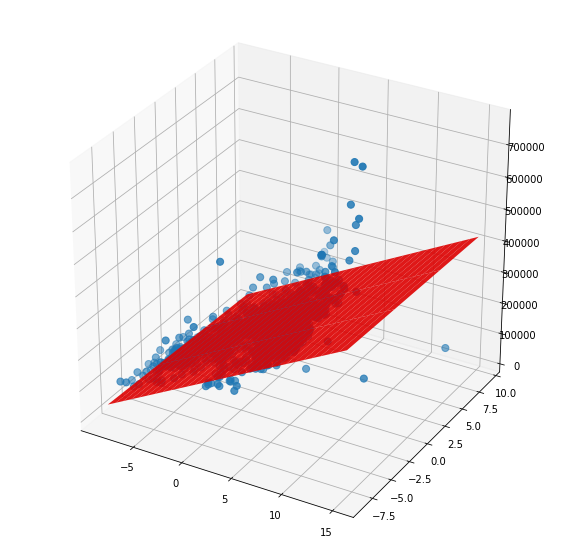

In [14]:
# now let's plot the regression function
min_xy = np.min(pca_data, axis = 0)
max_xy = np.max(pca_data, axis = 0)
x_values, y_values = np.meshgrid(np.linspace(min_xy[0], max_xy[0], 30), np.linspace(min_xy[1], max_xy[1], 30))
z_values = coefficients[0] * x_values + coefficients[1] * y_values + intercept

plt.figure(figsize = (10, 10))
ax = plt.axes(projection = '3d')
ax.scatter3D(x['PC1'], x['PC2'], y, s = 50)
ax.plot_surface(x_values, y_values, z_values, color='red', cstride = 1, alpha=0.9)